# Load SOAR Data (for training)
This notebook is a minimal example of how to load the RLDS SOAR data (e.g. for downstream training)

In [1]:
"""
1. Download a minimal SOAR dataset that's small to be used for testing
"""
import os
# use the downloading bash script, but pass in the path to the dummy dataset
SAVE_DIR = os.path.expanduser("~/dummy_soar_data")
URL_FILE = os.path.join(os.getcwd(), "test_dataset_urls.txt")

# call the bashscript
command = f"SAVE_DIR={SAVE_DIR} URL_FILE={URL_FILE} bash download_dataset.sh"
print(f"Executing command: {command}")
os.system(command)

Executing command: SAVE_DIR=/home/paulzhou/dummy_soar_data URL_FILE=/home/paulzhou/research/soar/soar_data/test_dataset_urls.txt bash download_dataset.sh
Saving files to /home/paulzhou/dummy_soar_data


--2024-07-26 01:39:30--  https://rail.eecs.berkeley.edu/datasets/soar_release/test/dataset_info.json
Resolving rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)... 128.32.244.190
Connecting to rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596
Saving to: ‘/home/paulzhou/dummy_soar_data/dataset_info.json’

     0K                                                       100% 38.8M=0s

2024-07-26 01:39:30 (38.8 MB/s) - ‘/home/paulzhou/dummy_soar_data/dataset_info.json’ saved [596/596]

--2024-07-26 01:39:30--  https://rail.eecs.berkeley.edu/datasets/soar_release/test/features.json
Resolving rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)... 128.32.244.190
Connecting to rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8713 (8.5K) [text/plain]
Saving to: ‘/home/paulzhou/dummy_soar_data/features.json’

     0K ........  

--2024-07-26 01:39:30--  https://rail.eecs.berkeley.edu/datasets/soar_release/test/soar_dataset-success.tfrecord-00000-of-00001
Resolving rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)... 128.32.244.190
Connecting to rail.eecs.berkeley.edu (rail.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88012692 (84M)
Saving to: ‘/home/paulzhou/dummy_soar_data/soar_dataset-success.tfrecord-00000-of-00001’

     0K .......... .......... .......... .......... ..........  0% 7.25M 12s
    50K .......... .......... .......... .......... ..........  0% 26.6M 7s
   100K .......... .......... .......... .......... ..........  0% 23.3M 6s
   150K .......... .......... .......... .......... ..........  0% 26.0M 5s
   200K .......... .......... .......... .......... ..........  0% 29.6M 5s
   250K .......... .......... .......... .......... ..........  0% 40.4M 4s
   300K .......... .......... .......... .......... ..........  0% 33.8M 4s
   350K

0

In [2]:
"""
2. Import the Dataloader class
"""
# install jaxrl_m if it it not already installed
# the package is located in model_training/jaxrl_m
try:
    import jaxrl_m
except ImportError:
    print("local jaxrl_m package not installed")
    jaxrl_m_path = os.path.abspath(os.path.join(os.getcwd(), "..", "model_training"))
    os.system(f"pip install -e {jaxrl_m_path}")
    
    # add the package path to sys.path
    import sys
    
    
# check that installation was successful
try:
    import jaxrl_m
except ImportError:
    print("Failed to correctly install jaxrl_m package")
    print("Please manually install the package with `pip install -e model_training`")
    exit(1)

# import dataloader class
from jaxrl_m.data.bridge_dataset import BridgeDataset

2024-07-26 01:39:40.425232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 01:39:40.425263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 01:39:40.426325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 01:39:40.432333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 01:39:41.217862: W tensorflow/compiler/tf2

In [3]:
"""
3. Load the dataset
"""
train_data = BridgeDataset(
    [SAVE_DIR],
    seed=0,
    batch_size=16,
    train=True,
)

2024-07-26 01:39:50.915194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10429 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2024-07-26 01:39:50.915731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10527 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-07-26 01:39:52.638610: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


Cause: Unable to locate the source code of <function _gcd_import at 0x7f56784cb400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f56784cb400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f56784cb400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


40it [00:00, 280.18it/s]


2024-07-26 01:39:58.953175: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f51482a6b20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-26 01:39:58.953250: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1721983199.026702  106254 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-07-26 01:39:59.027422: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-26 01:39:59.027517: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-26 01:39:59.027623: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-07-26 01:39:59.027747: E external/local_xla/xla/stream_executor/stream_executor_interna

Example batch keys: dict_keys(['observations', 'next_observations', 'actions', 'terminals'])
Actions shape: (16, 7), which is (batch_size, action_dim)
Observations shape: (16, 256, 256, 3), which is (batch_size, observation_dim)
Proprio shape: (16, 7), which is (batch_size, proprio_dim)


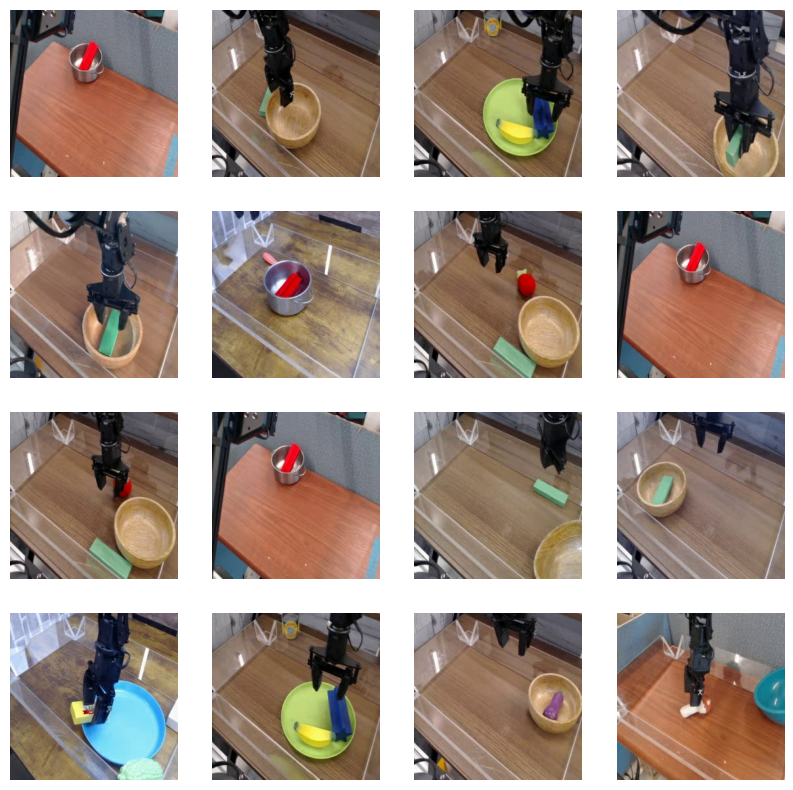

In [4]:
"""
4. Inspect an example batch
"""
import matplotlib.pyplot as plt

train_data_iter = train_data.iterator()
example_batch = next(train_data_iter)

print(f"Example batch keys: {example_batch.keys()}")
print(f"Actions shape: {example_batch['actions'].shape}, which is (batch_size, action_dim)")
print(f"Observations shape: {example_batch['observations']['image'].shape}, which is (batch_size, observation_dim)")
print(f"Proprio shape: {example_batch['observations']['proprio'].shape}, which is (batch_size, proprio_dim)")

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(example_batch['observations']['image'][i])
    plt.axis('off')
plt.show()

In [5]:
"""
5. Load only the success/failure split of the SOAR-data
If you wish, you could only load certain splits of the dataset. 
"""
success_data = BridgeDataset(
    [SAVE_DIR],
    data_splits=["success"],
    seed=0,
    batch_size=16,
    train=True,
)

failure_data = BridgeDataset(
    [SAVE_DIR],
    data_splits=["failure"],
    seed=0,
    batch_size=16,
    train=True,
)

2024-07-26 01:40:14.796289: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
40it [00:00, 288.16it/s]
2024-07-26 01:40:15.681296: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
40it [00:00, 1137.25it/s]


## More Advanced Usage
For more advanced usage, check out the arguments of the `BridgeDataset` class at [model_training/jaxrl_m/data/bridge_dataset.py](https://github.com/rail-berkeley/soar/blob/main/model_training/jaxrl_m/data/bridge_dataset.py).

An example of how this dataset is used is in `model_training/experiments/train.py`, and the configuration and arguments of the datasets are in `model_training/experiments/configs/train_config.py` and `model_training/experiments/configs/data_config.py`.